In [3]:
# !pip install opencv-python
# !pip install yattag

In [1]:
# ============================================= 
# Q-Learning for SnakeGame (Full Training, 5000 episodes)
# Metrics: Sample Efficiency, Exploration, Runtime, Convergence & Stability, Policy Behavior
# Includes gameplay recording of best episode
# =============================================

import numpy as np
import random
import time
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from snake_gym.envs import snake
from snake_gym.envs.modules import UP, DOWN, LEFT, RIGHT
import cv2
import warnings
warnings.filterwarnings("ignore")  # ⚙️ Keep output clean during long runs

pygame 2.6.1 (SDL 2.28.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# -----------------------
# 1. Environment Setup
# -----------------------
env = snake.SnakeGame()
n_actions = 4  # 0: UP, 1: DOWN, 2: LEFT, 3: RIGHT
dir_to_int = {UP:0, DOWN:1, LEFT:2, RIGHT:3}

In [4]:
# -----------------------
# 2. State Representation
# -----------------------
def get_state(env):
    """Simplified symbolic state: (dx, dy, direction)"""
    head_x, head_y = env.snake.get_head_position()
    apple_x, apple_y = env.apple.position
    dx = np.sign(apple_x - head_x)
    dy = np.sign(apple_y - head_y)
    direction = dir_to_int[env.snake.direction]
    return (dx, dy, direction)

In [5]:
# -----------------------
# 3. Hyperparameters
# -----------------------
episodes = 5000  # ⏳ Full training run
alpha = 0.1
gamma = 0.9
epsilon_init = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05

In [7]:
# -----------------------
# 4. Multi-run Setup for Convergence
# -----------------------
seeds = [42, 123, 999]
all_rewards = []
all_epsilons = []
all_steps = []
runtime_per_seed = []

In [8]:
# -----------------------
# 5. Training Loop
# -----------------------
for seed in seeds:
    random.seed(seed)
    np.random.seed(seed)
    
    Q = defaultdict(lambda: np.zeros(n_actions))
    rewards_per_episode = []
    moving_avg_rewards = deque(maxlen=10)
    epsilons = []
    steps_per_episode = []
    
    epsilon = epsilon_init
    start_time = time.time()
    
    for episode in range(episodes):
        env.reset()
        state = get_state(env)
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            # ε-greedy action selection
            if random.random() < epsilon:
                action = random.choice(range(n_actions))
            else:
                action = np.argmax(Q[state])
            
            next_state_img, reward, done, _ = env.step(action)
            next_state = get_state(env)
            
            # Q-learning update
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            
            state = next_state
            total_reward += reward
            steps += 1
        
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)
        moving_avg_rewards.append(total_reward)
        epsilons.append(epsilon)
        steps_per_episode.append(steps)
        
        # Show progress every 100 episodes (instead of every 10)
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(moving_avg_rewards)
            print(f"Seed {seed} | Episode {episode+1}/{episodes} | Avg Reward (last {len(moving_avg_rewards)}): {avg_reward:.2f} | ε={epsilon:.3f}")
        
        # 💾 Optional checkpoint every 1000 episodes
        if (episode + 1) % 1000 == 0:
            import pickle
            with open(f"checkpoint_seed_{seed}_ep_{episode+1}.pkl", "wb") as f:
                pickle.dump(dict(Q), f)
            print(f"💾 Checkpoint saved at episode {episode+1}")
    
    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_episode = total_time / episodes
    print(f"\nSeed {seed} | Total Training Time: {total_time:.2f}s | Avg per episode: {avg_time_per_episode:.3f}s\n")
    
    all_rewards.append(rewards_per_episode)
    all_epsilons.append(epsilons)
    all_steps.append(steps_per_episode)
    runtime_per_seed.append(avg_time_per_episode)

    # 🧠 Save trained Q-table for reuse
    import pickle
    with open(f"q_table_seed_{seed}.pkl", "wb") as f:
        pickle.dump(dict(Q), f)
    print(f"✅ Q-table saved as q_table_seed_{seed}.pkl")


KeyboardInterrupt: 

Seed 42 | Episodes to 80% max reward: None
Seed 123 | Episodes to 80% max reward: None
Seed 999 | Episodes to 80% max reward: None


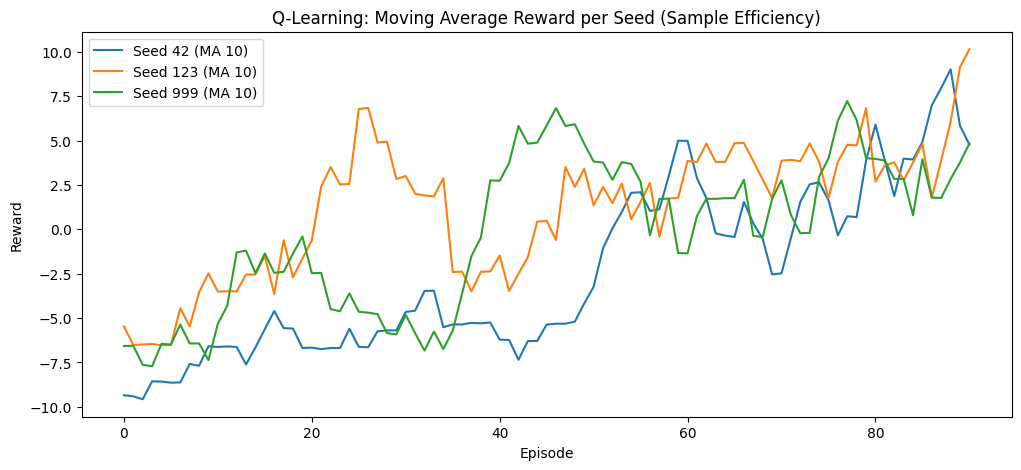

In [ ]:
# -----------------------
# 6. Sample Efficiency
# -----------------------
plt.figure(figsize=(12,5))
for i, rewards in enumerate(all_rewards):
    ma = np.convolve(rewards, np.ones(10)/10, mode='valid')
    max_reward = max(rewards)
    target = 0.8 * max_reward
    episodes_to_80 = next((idx for idx, r in enumerate(ma) if r >= target), None)
    print(f"Seed {seeds[i]} | Episodes to 80% max reward: {episodes_to_80}")
    plt.plot(ma, label=f"Seed {seeds[i]} (MA 10)")
plt.title("Q-Learning: Moving Average Reward per Seed (Sample Efficiency)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

In [ ]:
# -----------------------
# 7. Convergence & Stability Visualization
# -----------------------
plt.figure(figsize=(12,5))
for i, rewards in enumerate(all_rewards):
    ma = np.convolve(rewards, np.ones(10)/10, mode='valid')
    plt.plot(ma, label=f"Seed {seeds[i]}")
plt.title("Convergence Across Seeds (Learning Stability)")
plt.xlabel("Episode")
plt.ylabel("Moving Average Reward")
plt.legend()
plt.show()

# Variance across seeds
max_len = max(len(r) for r in all_rewards)
padded_rewards = [np.pad(r, (0, max_len - len(r)), 'edge') for r in all_rewards]
reward_variance_across_seeds = np.var(padded_rewards, axis=0)

plt.figure(figsize=(12,4))
plt.plot(reward_variance_across_seeds)
plt.title("Reward Variance Across Seeds (Learning Stability)")
plt.xlabel("Episode")
plt.ylabel("Variance")
plt.show()


In [ ]:
# -----------------------
# 8. Exploration Stability
# -----------------------
# Epsilon decay
plt.figure(figsize=(12,4))
for i, eps in enumerate(all_epsilons):
    plt.plot(eps, label=f"Seed {seeds[i]}")
plt.title("Epsilon Decay over Time")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

# Reward variance per 10-episode block
block_size = 10
plt.figure(figsize=(12,4))
for i, rewards in enumerate(all_rewards):
    variance = [np.var(rewards[j:j+block_size]) for j in range(0, len(rewards), block_size)]
    plt.plot(variance, label=f"Seed {seeds[i]}")
plt.title("Reward Variance per 10 Episodes")
plt.xlabel("Block")
plt.ylabel("Variance")
plt.legend()
plt.show()

In [ ]:
# -----------------------
# 9. Policy Behavior (Steps Survived)
# -----------------------
plt.figure(figsize=(12,4))
for i, steps in enumerate(all_steps):
    plt.plot(steps, label=f"Seed {seeds[i]}")
plt.title("Steps Survived per Episode (Policy Behavior)")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend()
plt.show()

In [ ]:
# -----------------------
# 10. Runtime / Computational Efficiency
# -----------------------
plt.figure(figsize=(6,4))
plt.bar([str(s) for s in seeds], runtime_per_seed)
plt.title("Average Time per Episode per Seed (Runtime)")
plt.xlabel("Seed")
plt.ylabel("Seconds per Episode")
plt.show()

In [ ]:
# -----------------------
# 11. Gameplay Recording: Best-Performing Episode
# -----------------------
# Find best episode
best_seed_idx = None
best_episode_idx = None
best_reward = -np.inf

for i, rewards in enumerate(all_rewards):
    ep_idx = np.argmax(rewards)
    if rewards[ep_idx] > best_reward:
        best_reward = rewards[ep_idx]
        best_seed_idx = i
        best_episode_idx = ep_idx

print(f"Best episode: Seed {seeds[best_seed_idx]}, Episode {best_episode_idx}, Reward {best_reward:.2f}")

# Replay and record frames
env.reset()
state = get_state(env)
done = False
frames = []

while not done:
    action = np.argmax(Q[state])  # deterministic
    frame, reward, done, _ = env.step(action)
    frames.append(frame)
    state = get_state(env)

print(f"Recorded {len(frames)} steps for the best episode.")

# Save frames as video
height, width, _ = frames[0].shape
out = cv2.VideoWriter('best_snake_episode.avi', cv2.VideoWriter_fourcc(*'XVID'), 15, (width, height))
for f in frames:
    # Convert RGBA to BGR for OpenCV
    if f.shape[2] == 4:
        f_bgr = cv2.cvtColor(f, cv2.COLOR_RGBA2BGR)
    else:
        f_bgr = f
    out.write(f_bgr)
out.release()
print("Video saved as 'best_snake_episode.avi'")

print("✅ Quick Test Complete: All 5 metrics logged, visualized, and best gameplay recorded.")

In [ ]:
# -----------------------
# 12. Generate HTML Summary Report
# -----------------------
from yattag import Doc, indent
import numpy as np
import os


html_report = "snake_qlearning_summary.html"

doc, tag, text, line = Doc().ttl()

with tag('html'):
    with tag('head'):
        line('title', 'Snake Q-Learning Summary Report')
    with tag('body'):
        line('h1', 'Snake Q-Learning Summary Report')
        
        with tag('h2'):
            text("Per-Seed Metrics")
        
        # Table header
        with tag('table', border="1", style="border-collapse:collapse; width:80%"):
            with tag('tr'):
                for col in ["Seed", "Episodes to 80% Max Reward", "Mean Reward", "Std Reward",
                            "Final Epsilon", "Avg Steps Survived", "Avg Runtime/Episode (s)"]:
                    line('th', col, style="padding:5px; text-align:center;")
            
            # Table rows
            for i, rewards in enumerate(all_rewards):
                ma = np.convolve(rewards, np.ones(10)/10, mode='valid')
                max_reward = max(rewards)
                target = 0.8 * max_reward
                episodes_to_80 = next((idx for idx, r in enumerate(ma) if r >= target), None)
                
                mean_reward = np.mean(rewards)
                std_reward = np.std(rewards)
                final_epsilon = all_epsilons[i][-1]
                avg_steps = np.mean(all_steps[i])
                avg_runtime = runtime_per_seed[i]
                
                with tag('tr'):
                    for val in [seeds[i], episodes_to_80 if episodes_to_80 is not None else "N/A",
                                f"{mean_reward:.2f}", f"{std_reward:.2f}",
                                f"{final_epsilon:.3f}", f"{avg_steps:.2f}", f"{avg_runtime:.3f}"]:
                        line('td', val, style="padding:5px; text-align:center;")

        
        # Best episode info
        with tag('h2'):
            text("Best Episode Across All Seeds")
        line('p', f"Seed {seeds[best_seed_idx]}, Episode {best_episode_idx}, Reward {best_reward:.2f}")
        line('p', "Gameplay video saved as 'best_snake_episode.avi'")

# Save HTML report
with open(html_report, "w") as f:
    f.write(indent(doc.getvalue()))

print(f"✅ HTML summary report saved as '{html_report}'")

Seed 42 | Episode 10/100 | Avg Reward (last 10): -9.35 | ε=0.951
Seed 42 | Episode 20/100 | Avg Reward (last 10): -6.63 | ε=0.905
Seed 42 | Episode 30/100 | Avg Reward (last 10): -6.67 | ε=0.860
Seed 42 | Episode 40/100 | Avg Reward (last 10): -4.66 | ε=0.818
Seed 42 | Episode 50/100 | Avg Reward (last 10): -6.22 | ε=0.778
Seed 42 | Episode 60/100 | Avg Reward (last 10): -3.24 | ε=0.740
Seed 42 | Episode 70/100 | Avg Reward (last 10): 4.98 | ε=0.704
Seed 42 | Episode 80/100 | Avg Reward (last 10): -2.48 | ε=0.670
Seed 42 | Episode 90/100 | Avg Reward (last 10): 5.90 | ε=0.637
Seed 42 | Episode 100/100 | Avg Reward (last 10): 4.77 | ε=0.606

Seed 42 | Total Training Time: 121.61s | Avg per episode: 1.216s

Seed 123 | Episode 10/100 | Avg Reward (last 10): -5.48 | ε=0.951
Seed 123 | Episode 20/100 | Avg Reward (last 10): -3.51 | ε=0.905
Seed 123 | Episode 30/100 | Avg Reward (last 10): -0.62 | ε=0.860
Seed 123 | Episode 40/100 | Avg Reward (last 10): 3.00 | ε=0.818
Seed 123 | Episode 50/

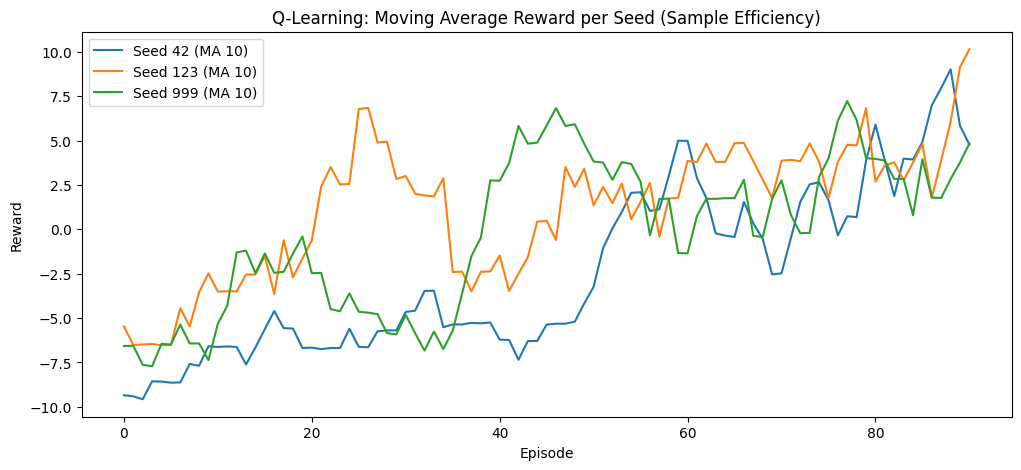

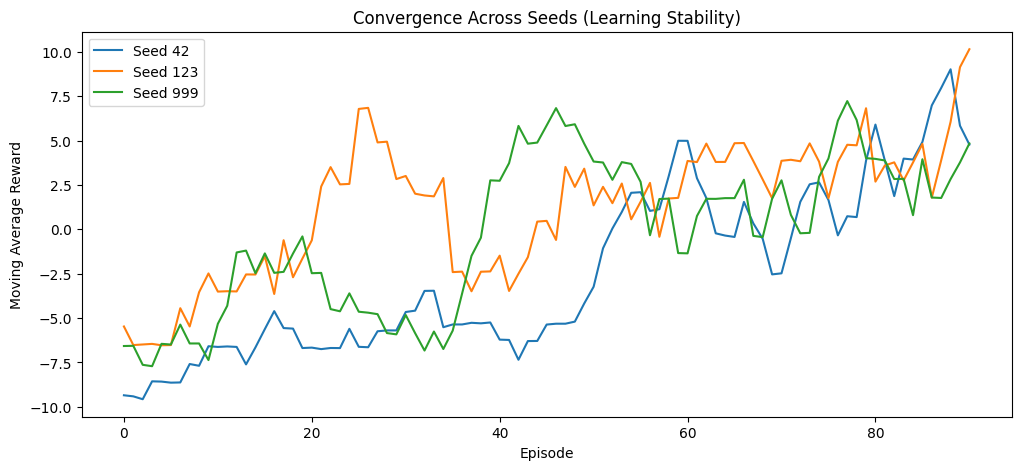

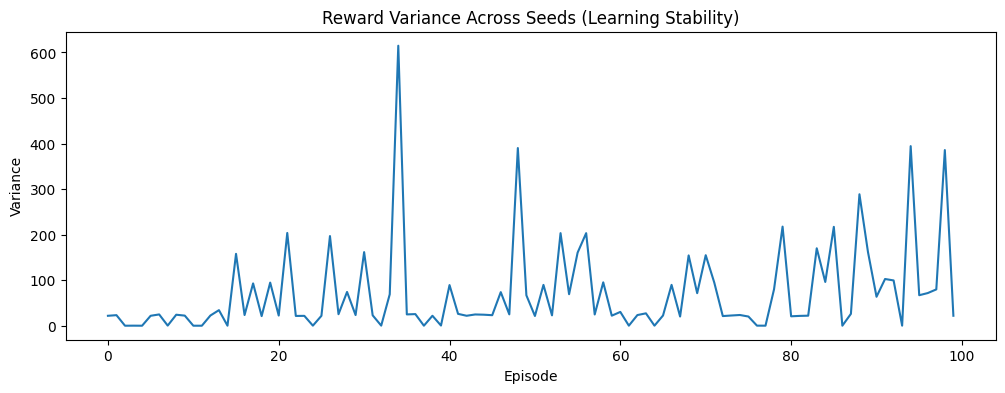

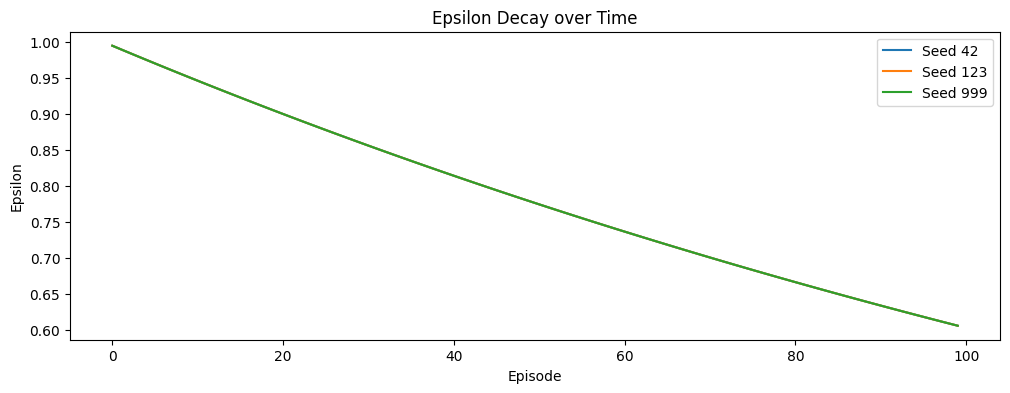

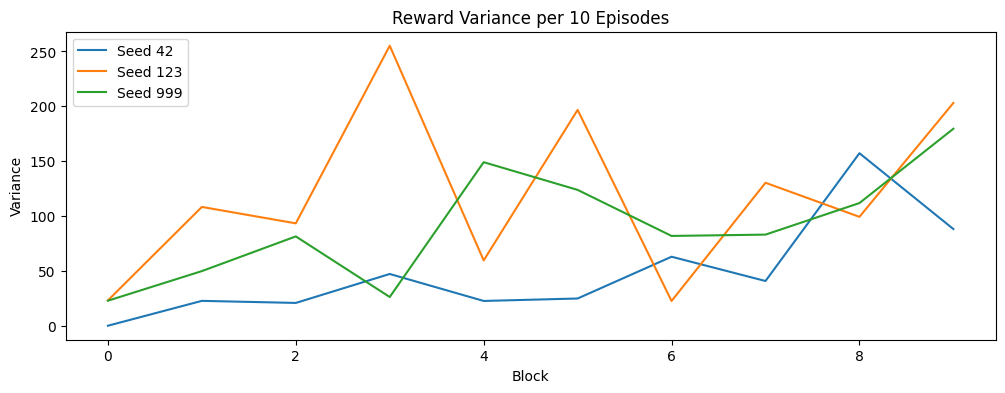

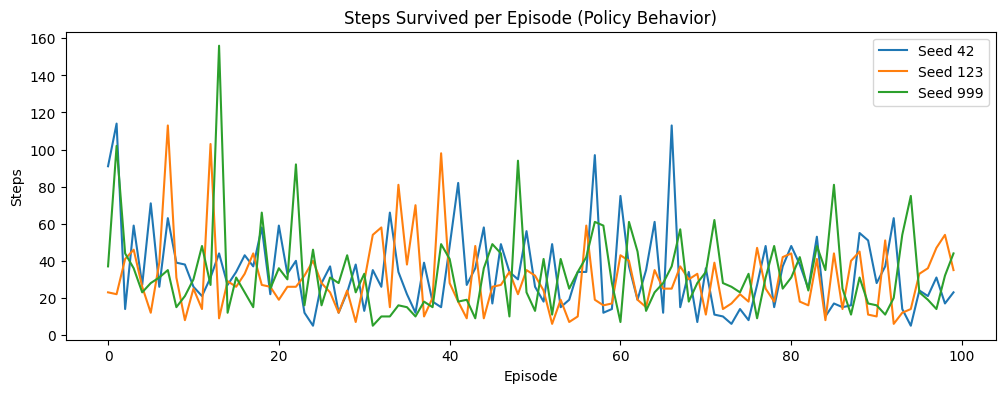

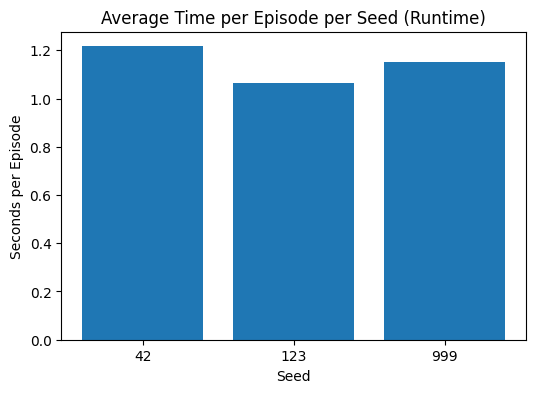

Best episode: Seed 123, Episode 34, Reward 42.95
Recorded 18 steps for the best episode.
Video saved as 'best_snake_episode.avi'
✅ Quick Test Complete: All 5 metrics logged, visualized, and best gameplay recorded.
✅ Table-style summary report saved as 'snake_qlearning_summary.html'


In [ ]:
# =============================================
# Q-Learning for SnakeGame (Quick Test, 100 episodes)
# Metrics: Sample Efficiency, Exploration, Runtime, Convergence & Stability, Policy Behavior
# Includes gameplay recording of best episode
# =============================================

import numpy as np
import random
import time
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from snake_gym.envs import snake
from snake_gym.envs.modules import UP, DOWN, LEFT, RIGHT
import cv2

# -----------------------
# 1. Environment Setup
# -----------------------
env = snake.SnakeGame()
n_actions = 4  # 0: UP, 1: DOWN, 2: LEFT, 3: RIGHT
dir_to_int = {UP:0, DOWN:1, LEFT:2, RIGHT:3}

# -----------------------
# 2. State Representation
# -----------------------
def get_state(env):
    """Simplified symbolic state: (dx, dy, direction)"""
    head_x, head_y = env.snake.get_head_position()
    apple_x, apple_y = env.apple.position
    dx = np.sign(apple_x - head_x)
    dy = np.sign(apple_y - head_y)
    direction = dir_to_int[env.snake.direction]
    return (dx, dy, direction)

# -----------------------
# 3. Hyperparameters
# -----------------------
episodes = 100  # Quick test
alpha = 0.1
gamma = 0.9
epsilon_init = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05

# -----------------------
# 4. Multi-run Setup for Convergence
# -----------------------
seeds = [42, 123, 999]
all_rewards = []
all_epsilons = []
all_steps = []
runtime_per_seed = []

# -----------------------
# 5. Training Loop
# -----------------------
for seed in seeds:
    random.seed(seed)
    np.random.seed(seed)
    
    Q = defaultdict(lambda: np.zeros(n_actions))
    rewards_per_episode = []
    moving_avg_rewards = deque(maxlen=10)
    epsilons = []
    steps_per_episode = []
    
    epsilon = epsilon_init
    start_time = time.time()
    
    for episode in range(episodes):
        env.reset()
        state = get_state(env)
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            # ε-greedy action selection
            if random.random() < epsilon:
                action = random.choice(range(n_actions))
            else:
                action = np.argmax(Q[state])
            
            next_state_img, reward, done, _ = env.step(action)
            next_state = get_state(env)
            
            # Q-learning update
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            
            state = next_state
            total_reward += reward
            steps += 1
        
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)
        moving_avg_rewards.append(total_reward)
        epsilons.append(epsilon)
        steps_per_episode.append(steps)
        
        # Print progress every 10 episodes
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(moving_avg_rewards)
            print(f"Seed {seed} | Episode {episode+1}/{episodes} | Avg Reward (last {len(moving_avg_rewards)}): {avg_reward:.2f} | ε={epsilon:.3f}")
    
    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_episode = total_time / episodes
    print(f"\nSeed {seed} | Total Training Time: {total_time:.2f}s | Avg per episode: {avg_time_per_episode:.3f}s\n")
    
    all_rewards.append(rewards_per_episode)
    all_epsilons.append(epsilons)
    all_steps.append(steps_per_episode)
    runtime_per_seed.append(avg_time_per_episode)

# -----------------------
# 6. Sample Efficiency
# -----------------------
plt.figure(figsize=(12,5))
for i, rewards in enumerate(all_rewards):
    ma = np.convolve(rewards, np.ones(10)/10, mode='valid')
    max_reward = max(rewards)
    target = 0.8 * max_reward
    episodes_to_80 = next((idx for idx, r in enumerate(ma) if r >= target), None)
    print(f"Seed {seeds[i]} | Episodes to 80% max reward: {episodes_to_80}")
    plt.plot(ma, label=f"Seed {seeds[i]} (MA 10)")
plt.title("Q-Learning: Moving Average Reward per Seed (Sample Efficiency)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

# -----------------------
# 7. Convergence & Stability Visualization
# -----------------------
plt.figure(figsize=(12,5))
for i, rewards in enumerate(all_rewards):
    ma = np.convolve(rewards, np.ones(10)/10, mode='valid')
    plt.plot(ma, label=f"Seed {seeds[i]}")
plt.title("Convergence Across Seeds (Learning Stability)")
plt.xlabel("Episode")
plt.ylabel("Moving Average Reward")
plt.legend()
plt.show()

# Variance across seeds
max_len = max(len(r) for r in all_rewards)
padded_rewards = [np.pad(r, (0, max_len - len(r)), 'edge') for r in all_rewards]
reward_variance_across_seeds = np.var(padded_rewards, axis=0)

plt.figure(figsize=(12,4))
plt.plot(reward_variance_across_seeds)
plt.title("Reward Variance Across Seeds (Learning Stability)")
plt.xlabel("Episode")
plt.ylabel("Variance")
plt.show()

# -----------------------
# 8. Exploration Stability
# -----------------------
# Epsilon decay
plt.figure(figsize=(12,4))
for i, eps in enumerate(all_epsilons):
    plt.plot(eps, label=f"Seed {seeds[i]}")
plt.title("Epsilon Decay over Time")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

# Reward variance per 10-episode block
block_size = 10
plt.figure(figsize=(12,4))
for i, rewards in enumerate(all_rewards):
    variance = [np.var(rewards[j:j+block_size]) for j in range(0, len(rewards), block_size)]
    plt.plot(variance, label=f"Seed {seeds[i]}")
plt.title("Reward Variance per 10 Episodes")
plt.xlabel("Block")
plt.ylabel("Variance")
plt.legend()
plt.show()

# -----------------------
# 9. Policy Behavior (Steps Survived)
# -----------------------
plt.figure(figsize=(12,4))
for i, steps in enumerate(all_steps):
    plt.plot(steps, label=f"Seed {seeds[i]}")
plt.title("Steps Survived per Episode (Policy Behavior)")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend()
plt.show()

# -----------------------
# 10. Runtime / Computational Efficiency
# -----------------------
plt.figure(figsize=(6,4))
plt.bar([str(s) for s in seeds], runtime_per_seed)
plt.title("Average Time per Episode per Seed (Runtime)")
plt.xlabel("Seed")
plt.ylabel("Seconds per Episode")
plt.show()

# -----------------------
# 11. Gameplay Recording: Best-Performing Episode
# -----------------------
# Find best episode
best_seed_idx = None
best_episode_idx = None
best_reward = -np.inf

for i, rewards in enumerate(all_rewards):
    ep_idx = np.argmax(rewards)
    if rewards[ep_idx] > best_reward:
        best_reward = rewards[ep_idx]
        best_seed_idx = i
        best_episode_idx = ep_idx

print(f"Best episode: Seed {seeds[best_seed_idx]}, Episode {best_episode_idx}, Reward {best_reward:.2f}")

# Replay and record frames
env.reset()
state = get_state(env)
done = False
frames = []

while not done:
    action = np.argmax(Q[state])  # deterministic
    frame, reward, done, _ = env.step(action)
    frames.append(frame)
    state = get_state(env)

print(f"Recorded {len(frames)} steps for the best episode.")

# Save frames as video
height, width, _ = frames[0].shape
out = cv2.VideoWriter('best_snake_episode.avi', cv2.VideoWriter_fourcc(*'XVID'), 15, (width, height))
for f in frames:
    # Convert RGBA to BGR for OpenCV
    if f.shape[2] == 4:
        f_bgr = cv2.cvtColor(f, cv2.COLOR_RGBA2BGR)
    else:
        f_bgr = f
    out.write(f_bgr)
out.release()
print("Video saved as 'best_snake_episode.avi'")

print("✅ Quick Test Complete: All 5 metrics logged, visualized, and best gameplay recorded.")

# -----------------------
# 12. Generate HTML Summary Report
# -----------------------
from yattag import Doc, indent
import numpy as np
import os


html_report = "snake_qlearning_summary.html"

doc, tag, text, line = Doc().ttl()

with tag('html'):
    with tag('head'):
        line('title', 'Snake Q-Learning Summary Report')
    with tag('body'):
        line('h1', 'Snake Q-Learning Summary Report')
        
        with tag('h2'):
            text("Per-Seed Metrics")
        
        # Table header
        with tag('table', border="1", style="border-collapse:collapse; width:80%"):
            with tag('tr'):
                for col in ["Seed", "Episodes to 80% Max Reward", "Mean Reward", "Std Reward",
                            "Final Epsilon", "Avg Steps Survived", "Avg Runtime/Episode (s)"]:
                    line('th', col, style="padding:5px; text-align:center;")
            
            # Table rows
            for i, rewards in enumerate(all_rewards):
                ma = np.convolve(rewards, np.ones(10)/10, mode='valid')
                max_reward = max(rewards)
                target = 0.8 * max_reward
                episodes_to_80 = next((idx for idx, r in enumerate(ma) if r >= target), None)
                
                mean_reward = np.mean(rewards)
                std_reward = np.std(rewards)
                final_epsilon = all_epsilons[i][-1]
                avg_steps = np.mean(all_steps[i])
                avg_runtime = runtime_per_seed[i]
                
                with tag('tr'):
                    for val in [seeds[i], episodes_to_80 if episodes_to_80 is not None else "N/A",
                                f"{mean_reward:.2f}", f"{std_reward:.2f}",
                                f"{final_epsilon:.3f}", f"{avg_steps:.2f}", f"{avg_runtime:.3f}"]:
                        line('td', val, style="padding:5px; text-align:center;")

        
        # Best episode info
        with tag('h2'):
            text("Best Episode Across All Seeds")
        line('p', f"Seed {seeds[best_seed_idx]}, Episode {best_episode_idx}, Reward {best_reward:.2f}")
        line('p', "Gameplay video saved as 'best_snake_episode.avi'")

# Save HTML report
with open(html_report, "w") as f:
    f.write(indent(doc.getvalue()))

print(f"✅ HTML summary report saved as '{html_report}'")


In [5]:
# import snake_gym
# from snake_gym.envs import snake
# import matplotlib.pyplot as plt

# env = snake.SnakeGame()
# state = env.reset()

# plt.imshow(state)
# plt.title("Initial Game Frame")
# plt.show()

# for i in range(5):
#     state, reward, done, info = env.step(i % 4)
#     print(f"Step {i}: reward={reward}, done={done}")


In [6]:
# # =============================================
# # Q-Learning for SnakeGame (symbolic state)
# # =============================================

# import numpy as np
# import random
# import time
# import matplotlib.pyplot as plt
# from collections import defaultdict, deque
# from snake_gym.envs import snake
# from snake_gym.envs.modules import UP, DOWN, LEFT, RIGHT

# # -----------------------
# # 1. Environment Setup
# # -----------------------
# env = snake.SnakeGame()
# n_actions = 4  # 0: UP, 1: DOWN, 2: LEFT, 3: RIGHT

# # Map directions to integer for state
# dir_to_int = {UP:0, DOWN:1, LEFT:2, RIGHT:3}

# # -----------------------
# # 2. State Representation
# # -----------------------
# def get_state(env):
#     """Return a simplified state: (dx, dy, current_direction)"""
#     head_x, head_y = env.snake.get_head_position()
#     apple_x, apple_y = env.apple.position

#     dx = np.sign(apple_x - head_x)
#     dy = np.sign(apple_y - head_y)
#     direction = dir_to_int[env.snake.direction]

#     return (dx, dy, direction)

# # -----------------------
# # 3. Hyperparameters
# # -----------------------
# episodes = 500
# alpha = 0.1           # learning rate
# gamma = 0.9           # discount factor
# epsilon = 1.0         # exploration rate
# epsilon_decay = 0.995
# epsilon_min = 0.05

# # Q-table
# Q = defaultdict(lambda: np.zeros(n_actions))

# # For logging
# rewards_per_episode = []
# moving_avg_rewards = deque(maxlen=100)

# # -----------------------
# # 4. Training Loop
# # -----------------------
# start_time = time.time()

# for episode in range(episodes):
#     env.reset()
#     state = get_state(env)
#     done = False
#     total_reward = 0

#     while not done:
#         # ε-greedy action selection
#         if random.random() < epsilon:
#             action = random.choice(range(n_actions))
#         else:
#             action = np.argmax(Q[state])

#         next_state_img, reward, done, _ = env.step(action)
#         next_state = get_state(env)

#         # Q-learning update
#         Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
#         state = next_state
#         total_reward += reward

#     # Decay epsilon
#     epsilon = max(epsilon_min, epsilon * epsilon_decay)
#     rewards_per_episode.append(total_reward)
#     moving_avg_rewards.append(total_reward)

#     # Print progress every 100 episodes
#     if (episode + 1) % 100 == 0:
#         avg_reward = np.mean(moving_avg_rewards)
#         print(f"Episode {episode+1}/{episodes} | Avg Reward (last 100): {avg_reward:.2f} | ε={epsilon:.3f}")

# end_time = time.time()
# training_time = end_time - start_time
# print(f"\nTotal Training Time: {training_time:.2f} seconds")

# # -----------------------
# # 5. Plot Learning Curve
# # -----------------------
# plt.figure(figsize=(12,5))
# plt.plot(rewards_per_episode, label='Reward per Episode', alpha=0.4)
# plt.plot(np.convolve(rewards_per_episode, np.ones(100)/100, mode='valid'),
#          label='Moving Average (100)')
# plt.title('Q-Learning Training Performance (Snake)')
# plt.xlabel('Episodes')
# plt.ylabel('Total Reward')
# plt.legend()
# plt.show()
